In [1]:
# Imports
import matplotlib.pyplot as plt
import pickle
import numpy as np
from scipy import interpolate
import math
import itertools

In [2]:
# Load the natural chlorophyll datasest

chlorophyll_spectra = pickle.load(open('./natural_chlorophyll_spectra.pkl', 'rb'))

In [3]:
# Print out the compounds
print(chlorophyll_spectra.keys())

dict_keys(['CHL259_BChl a, Pyr ', 'CHL229_Chl c1 phytyl, THF ', 'CHL154_Chl e6, EtOH ', 'CHL168_Purpurin 18, EtOH ', 'CHL126_3-Et-7-CHO PyroPhebide a ME, DCM ', 'CHL194_BChl d, Pyr ', 'CHL070_Chl b2, Et2O ', 'CHL127_3-Et-8-CHO PyroPhebide a ME, DCM ', 'CHL004_Chl a, C6H6 ', 'CHL241_8-Vinyl ProtoChl a, THF ', 'CHL029_Ch f, C6H6 ', 'CHL204_BChl f [E,E], THF ', 'CHL215_Chl c, Et2O ', 'CHL034_Ch f, Pyr ', 'CHL084_Phebide a, EtOH ', 'CHL205_BChl f [E,M], Et2O ', 'CHL125_3-CHO PyroPhebide a ME, DCM ', 'CHL120_3-Et-7-vinyl PyroPhebide a ME, DCM ', 'CHL261_BChl a, Tol ', 'CHL117_PyroPhebide a ME, DCM ', 'CHL014_Chl b, Et2O ', 'CHL249_ProtoPhe a, Et2O ', 'CHL128_3-Et-12-CHO PyroPhebide a ME, DCM ', 'CHL239_ProtoChl a, THF ', 'CHL191_BChl c [E,E], THF ', 'CHL273_BPhe a, Et2O ', 'CHL233_Phe c2, Ace ', 'CHL122_3-Et-12-vinyl PyroPhebide a ME, DCM ', 'CHL232_Phe c1, Ace ', 'CHL114_PyroPhebide a, DCM ', 'CHL047_Phe b, Et2O ', 'CHL188_BChl c, Pyr ', 'CHL021_Chl d, Et2O ', 'CHL196_BChl d [E,E], THF ', 

In [4]:
# Function to compute the relative spectral overlap integral (sufficient for a weight)

# constants
N_A = 6.02214076e23
ln10 = math.log(10)
pi = math.pi

def compute_relative_J(lambda_em_nm, int_em, lambda_abs_nm, absorbance, grid_res=1.0):
    """
    Compute relative spectral overlap J_rel = ∫ F_D(λ) * A_A(λ) * λ^4 dλ
    using absorbance A instead of ε. Can be used for ranking/comparison if all spectra share the same c*ℓ.
    Inputs:
      - lambda_em_nm, int_em: donor emission wavelengths (nm) and intensities (arb units)
      - lambda_abs_nm, absorbance: acceptor wavelengths (nm) and absorbance A(λ) (unitless OD)
      - grid_res: Resolution of the wavelength grid for numerical integration, nominally 1 nm spacing over overlap.
    Returns:
      - J_rel (numeric, arbitrary units) and the grid used (nm)
    """
    lam_min = max(min(lambda_em_nm), min(lambda_abs_nm))
    lam_max = min(max(lambda_em_nm), max(lambda_abs_nm))
    grid_nm = np.arange(lam_min, lam_max + grid_res, grid_res)

    f_em = interpolate.interp1d(lambda_em_nm, int_em, bounds_error=False, fill_value=0.0)
    f_abs = interpolate.interp1d(lambda_abs_nm, absorbance, bounds_error=False, fill_value=0.0)
    I_D = f_em(grid_nm)
    A_A = f_abs(grid_nm)

    delta = np.mean(np.diff(grid_nm))  # nm
    area = np.sum(I_D) * delta
    if area <= 0:
        raise ValueError("Donor emission has zero area after interpolation.")
    F_D = I_D / area

    # Use lambda in nm but include nm^4 factor; since units are arbitrary, J_rel is arbitrary
    J_rel = np.sum(F_D * A_A * (grid_nm**4)) * delta

    return J_rel, grid_nm

In [5]:
# Function to plot the emission and absorption spectrum
def plot_spectra(compound_a, compound_b, spectra, with_overlap=True, save_path=None):
    """
    Compound A is emitting, compound B is absorbing
    """
    spectra_a = spectra[compound_a]
    spectra_b = spectra[compound_b]
    fig, ax = plt.subplots()
    ax.plot(spectra_a['emission']['wavelength'], spectra_a['emission']['intensity'], label=(compound_a + ' emission'), color='red')
    ax.plot(spectra_b['absorption']['wavelength'], spectra_b['absorption']['intensity'], label=(compound_b + ' absorption'), color='blue')
    ax.legend()
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Intensity')
    if with_overlap:
        overlap = compute_pairwise_overlap(compound_a, compound_b, spectra)
        if np.isnan(overlap):
            ax.set_title('No Spectral Overlap')
        else:
            ttl = f"Spectral Overlap = {overlap:.2e}"
            ax.set_title(ttl)
    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path)


In [6]:
# Function to compute pairwise spectral integral
def compute_pairwise_overlap(compound_a, compound_b, spectra):
    """
    Compound A is emitting, compound B is absorbing
    """

    spectra_a = spectra[compound_a]
    spectra_b = spectra[compound_b]

    spectral_overlap, grid = compute_relative_J(spectra_a['emission']['wavelength'], spectra_a['emission']['intensity'], spectra_b['absorption']['wavelength'], spectra_b['absorption']['intensity'])

    return spectral_overlap


/opt/miniconda3/envs/microproject/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/microproject/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/ct/skkjhdjx73bdx_51jn4zq68h0000gn/T/ipykernel_32717/3881930966.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


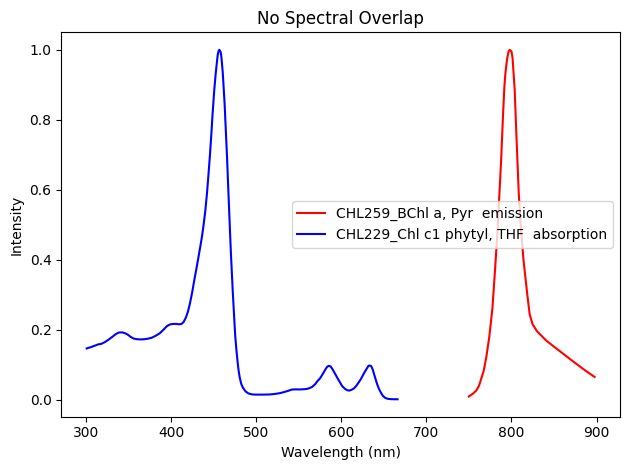

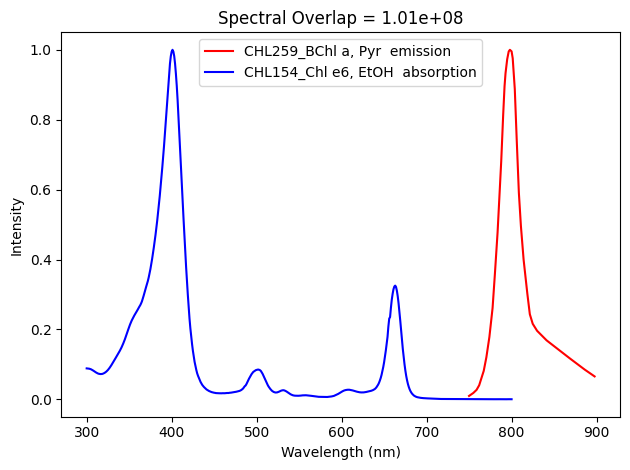

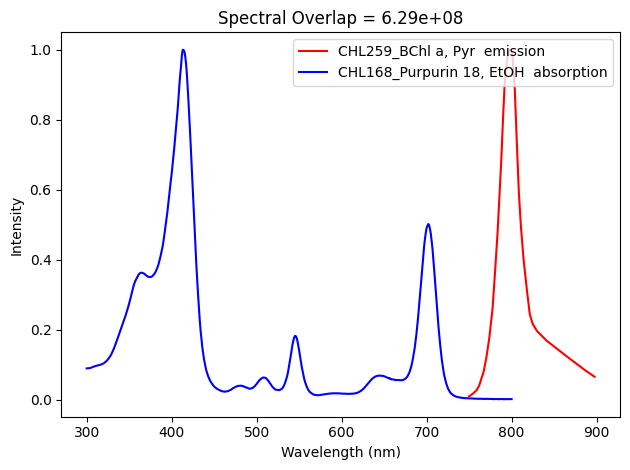

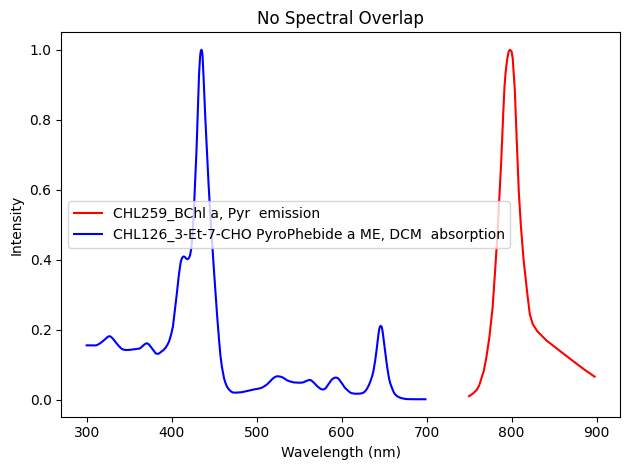

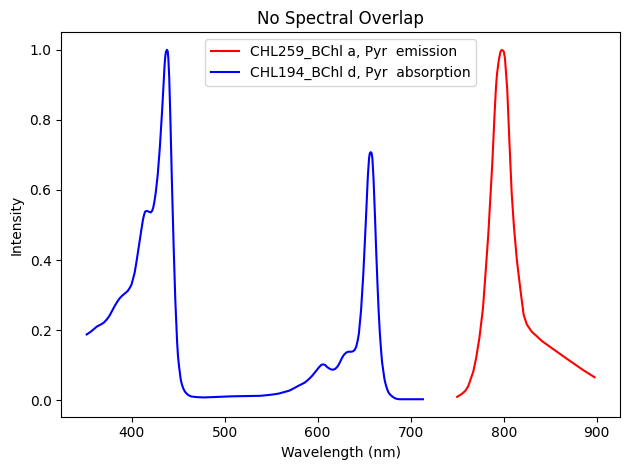

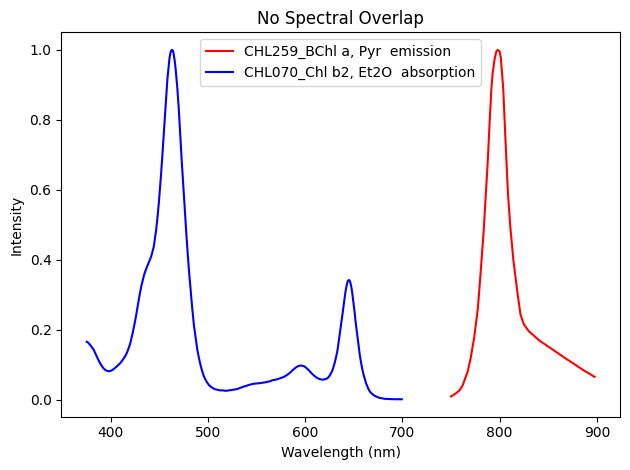

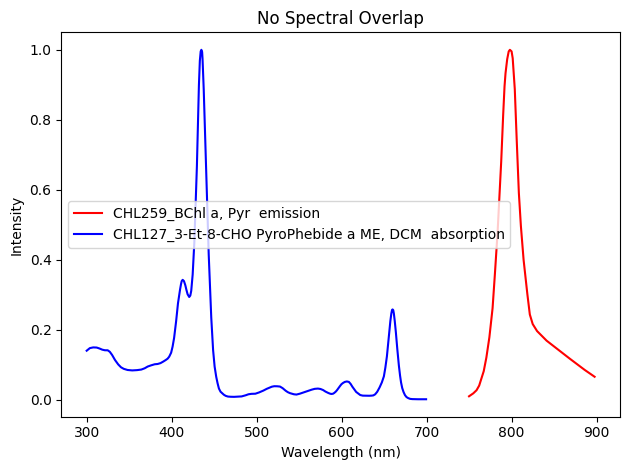

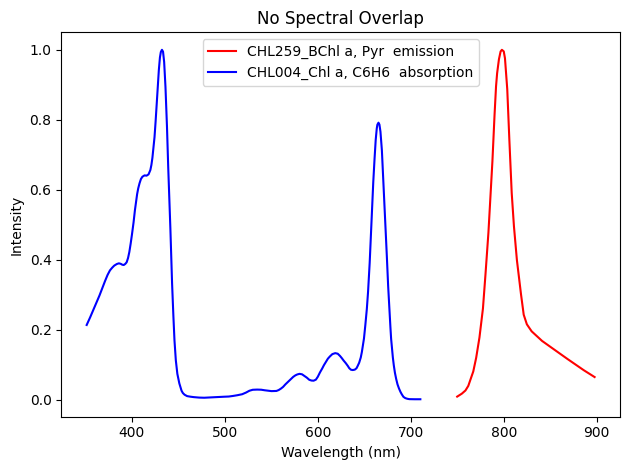

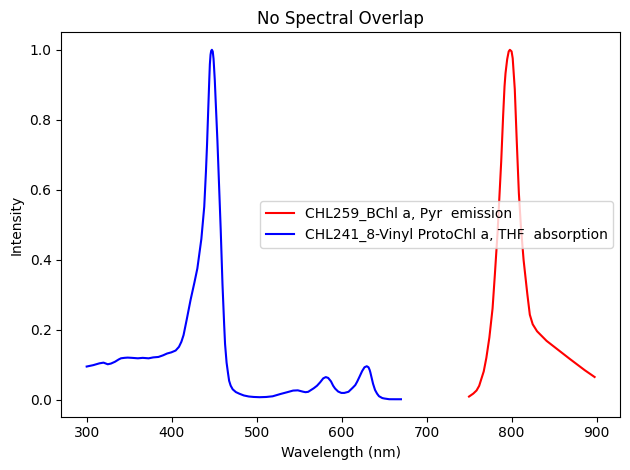

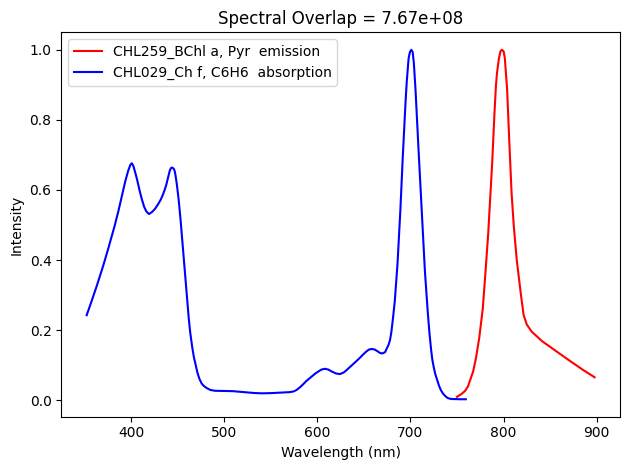

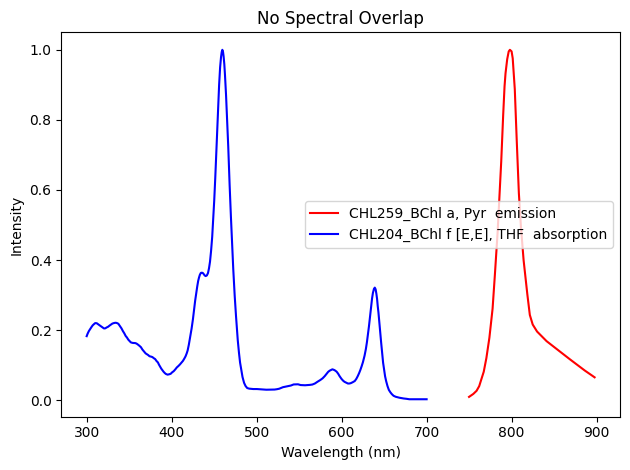

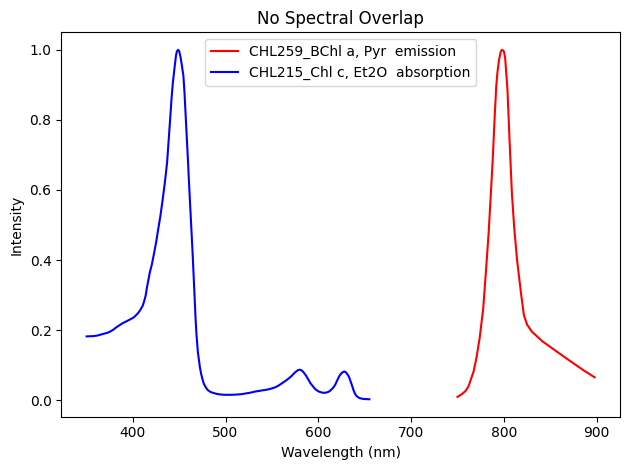

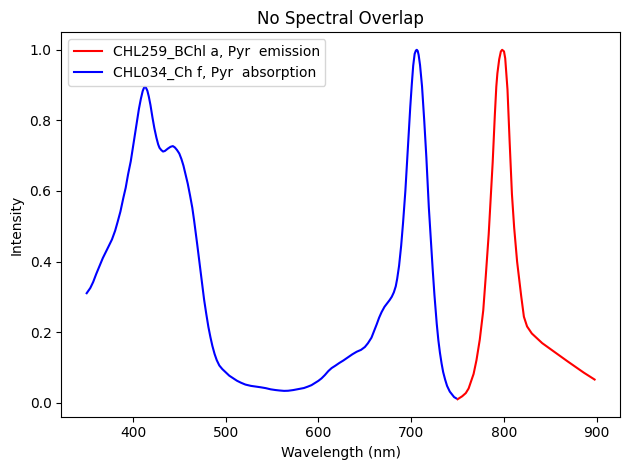

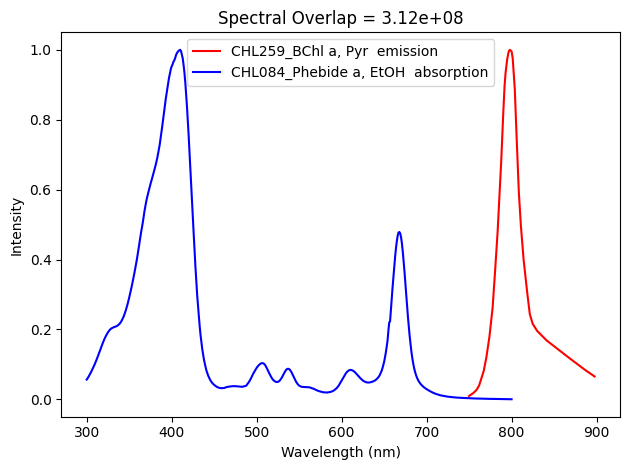

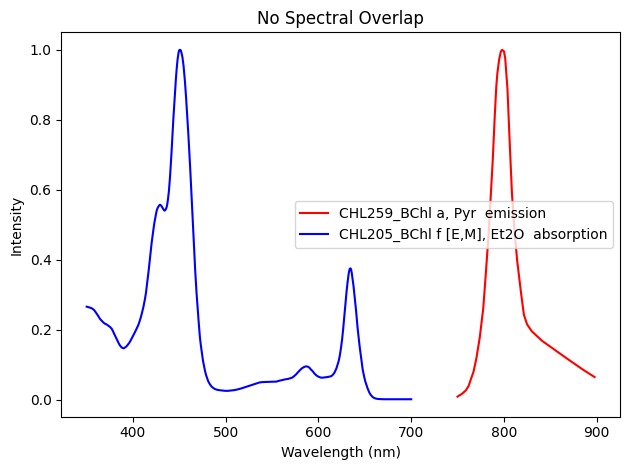

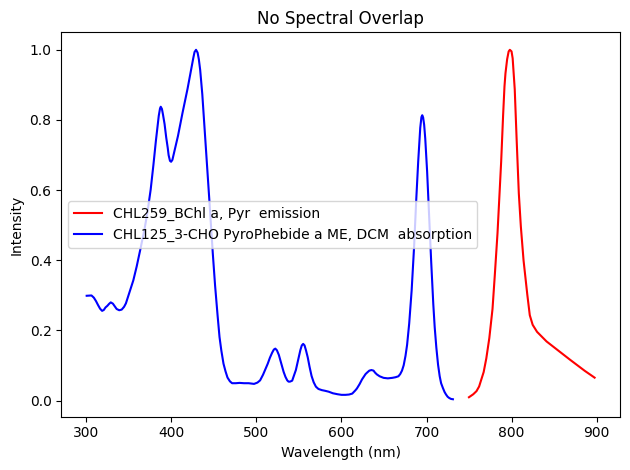

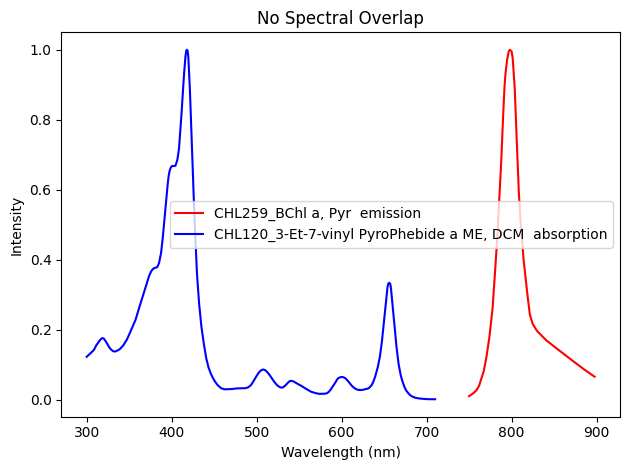

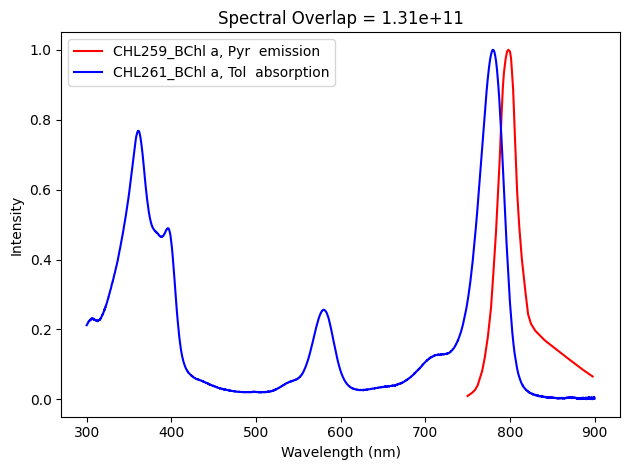

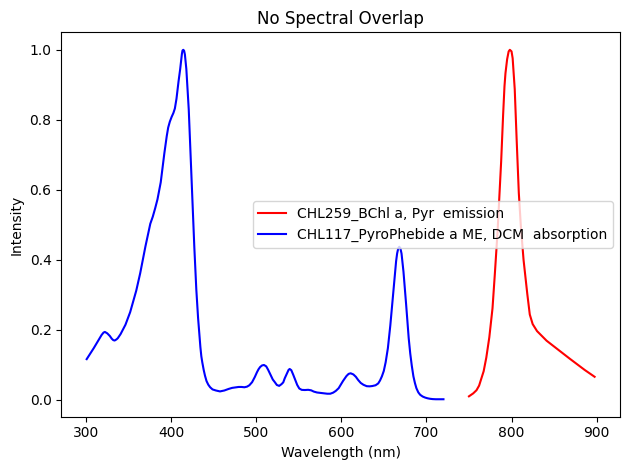

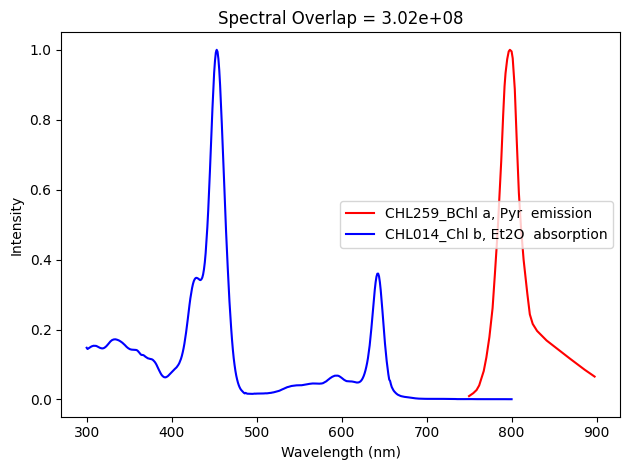

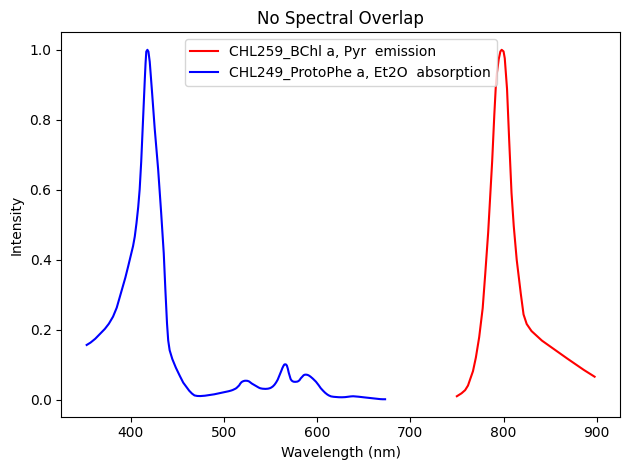

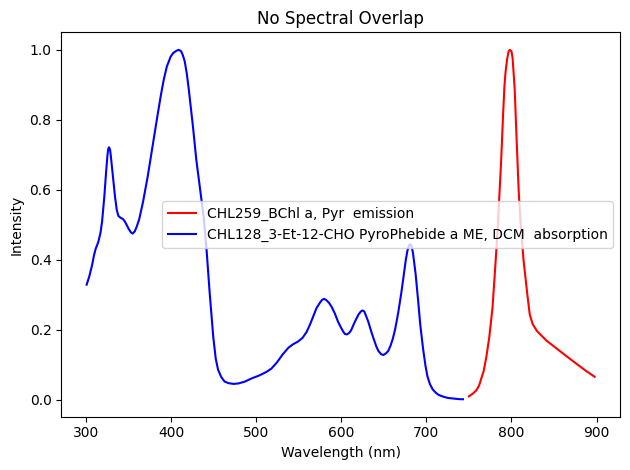

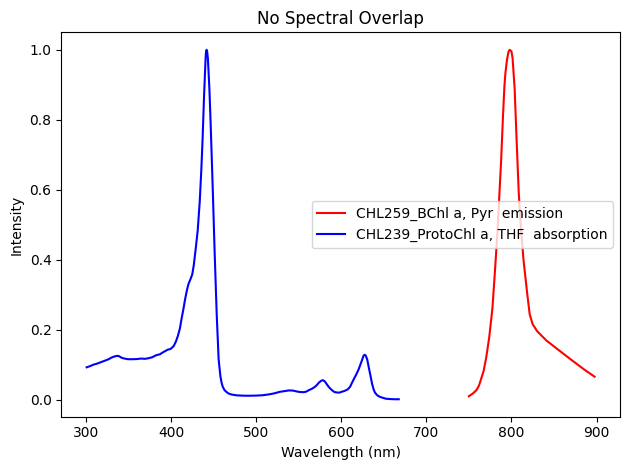

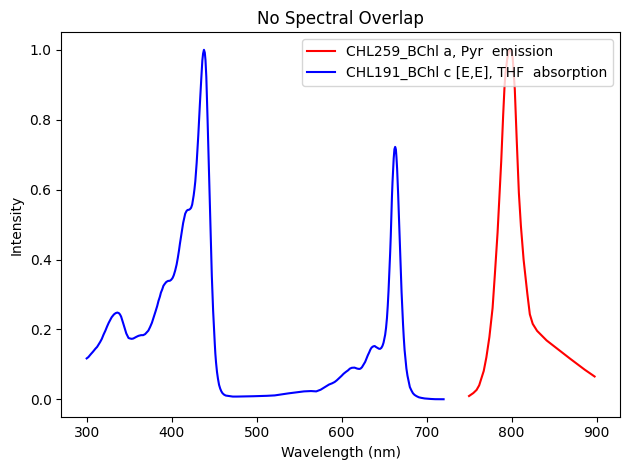

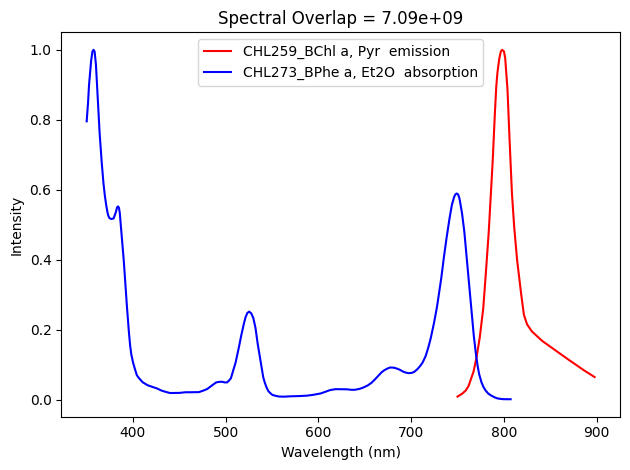

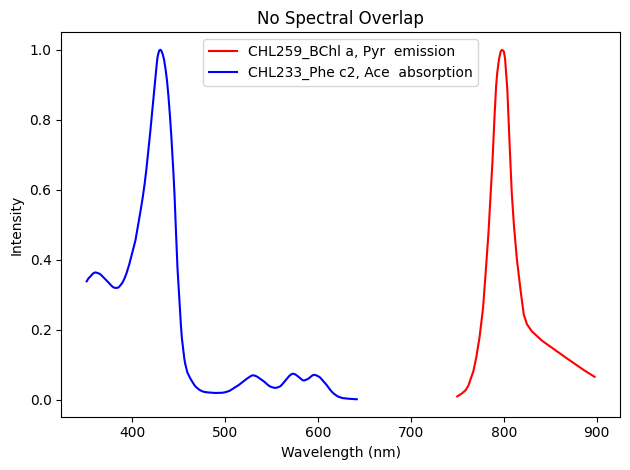

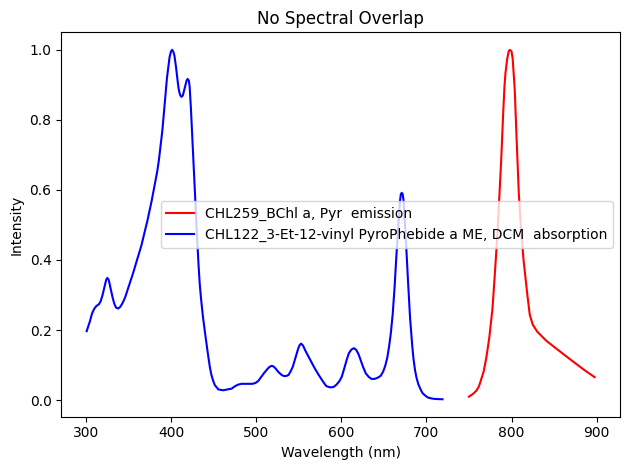

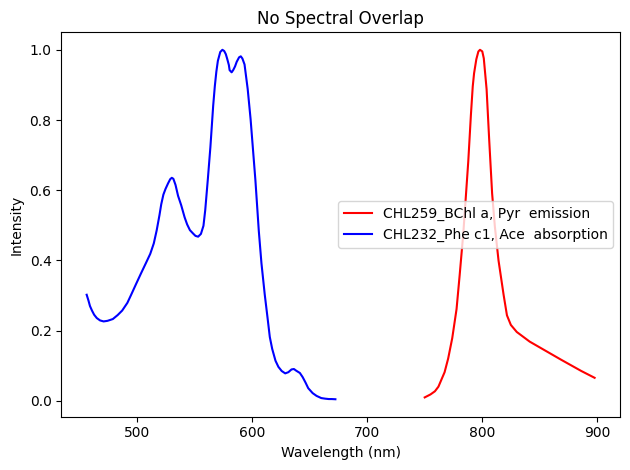

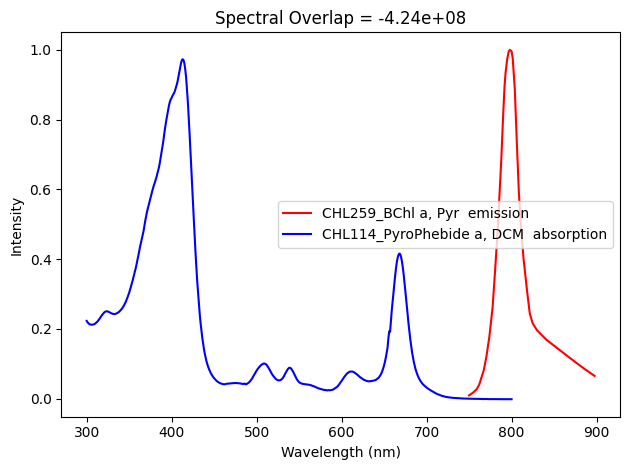

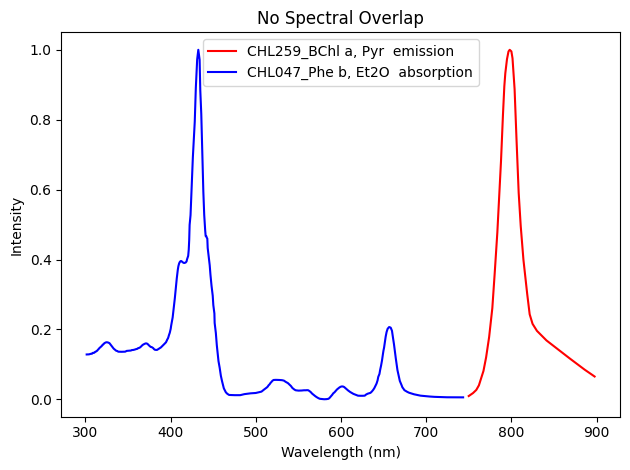

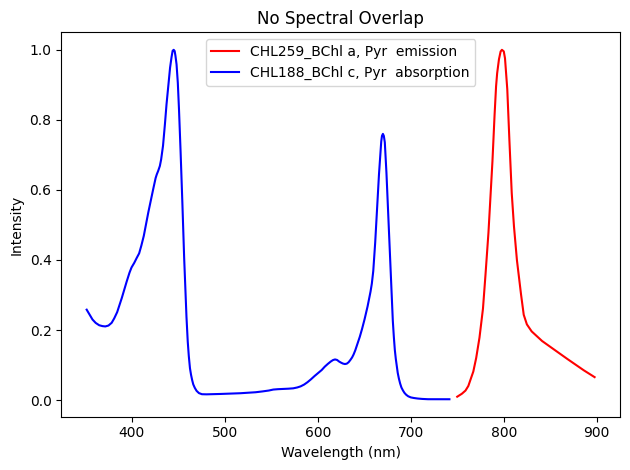

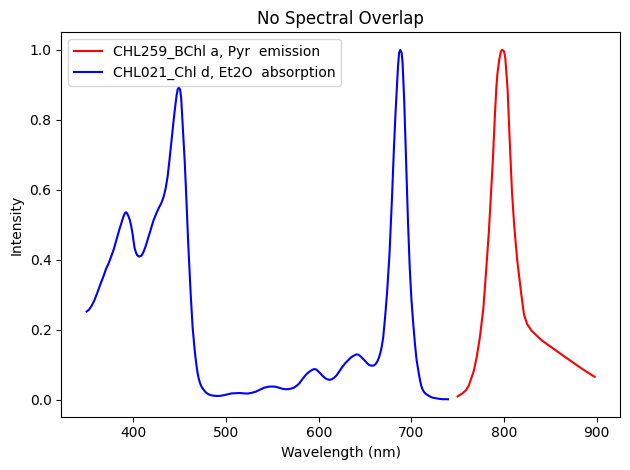

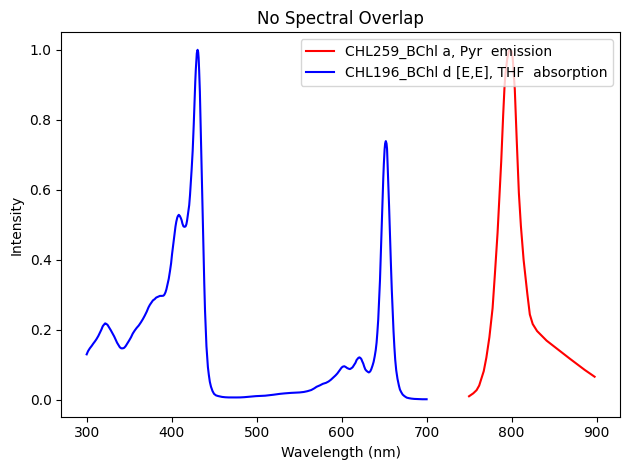

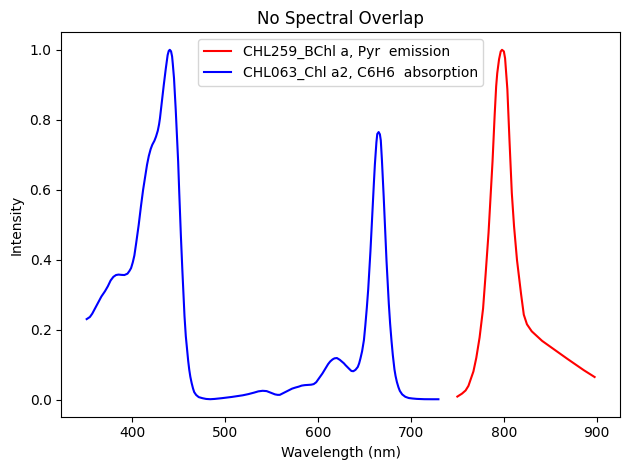

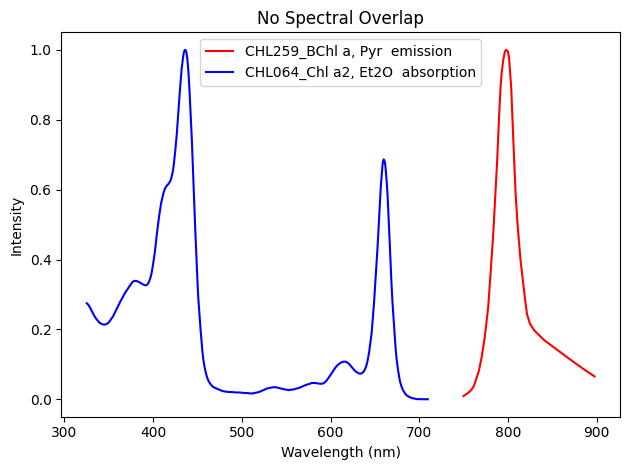

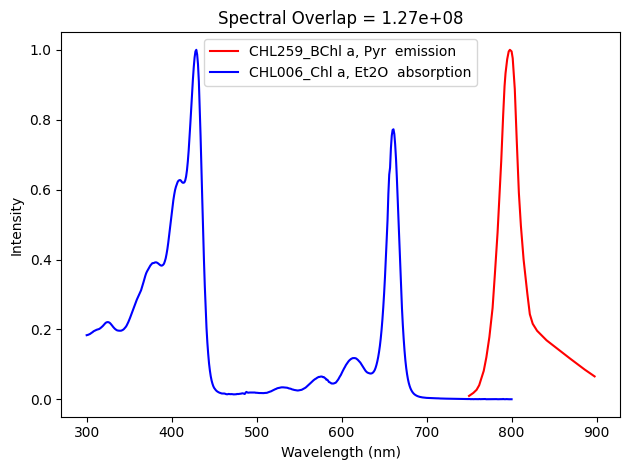

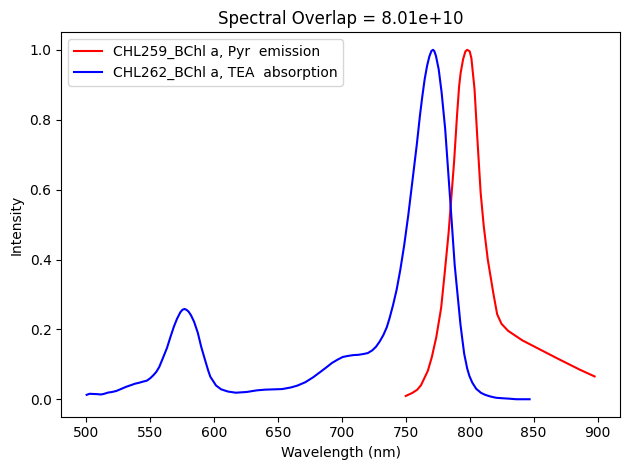

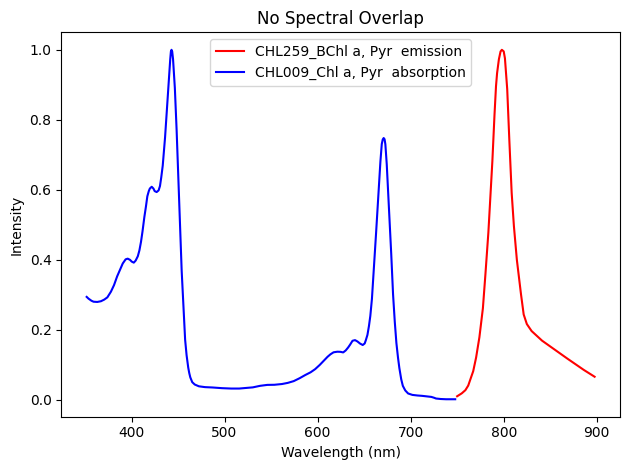

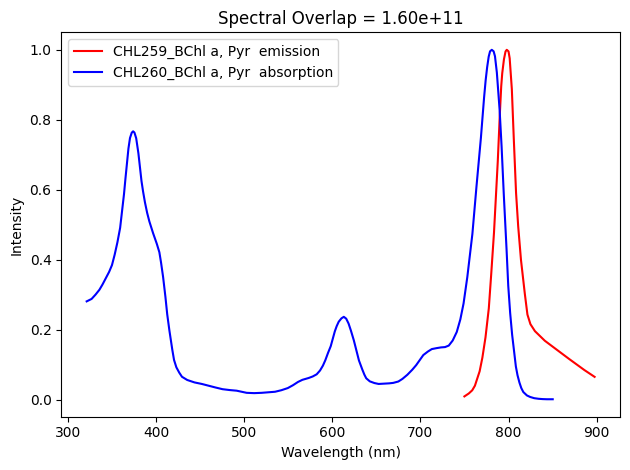

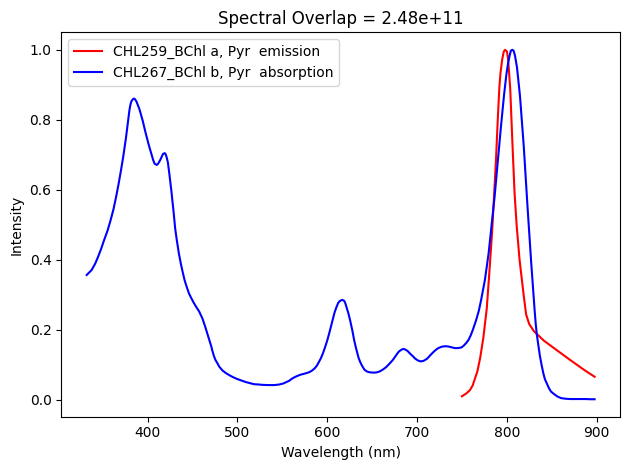

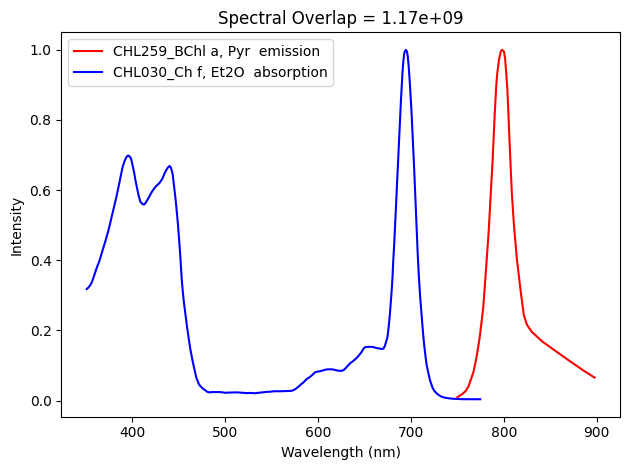

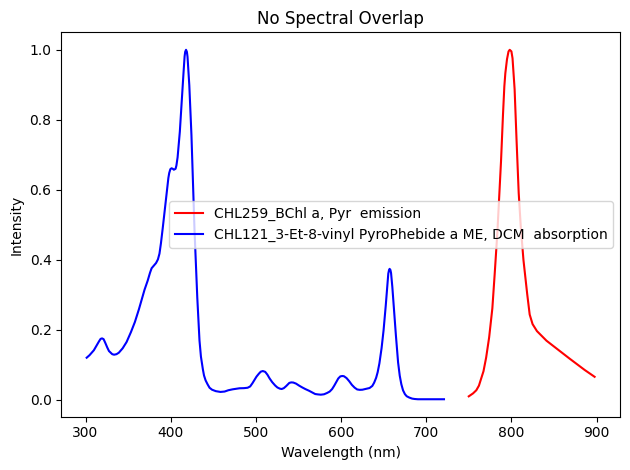

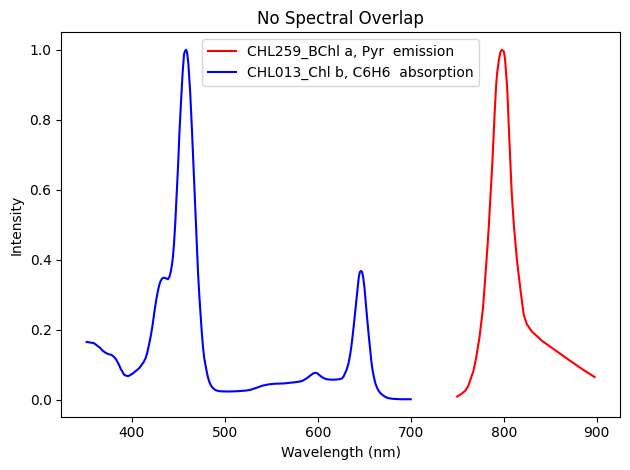

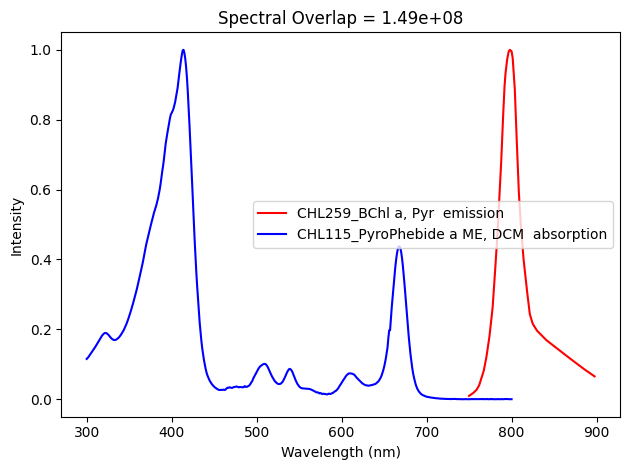

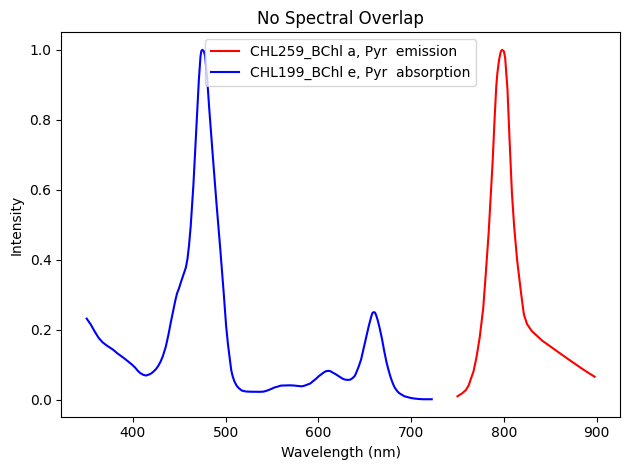

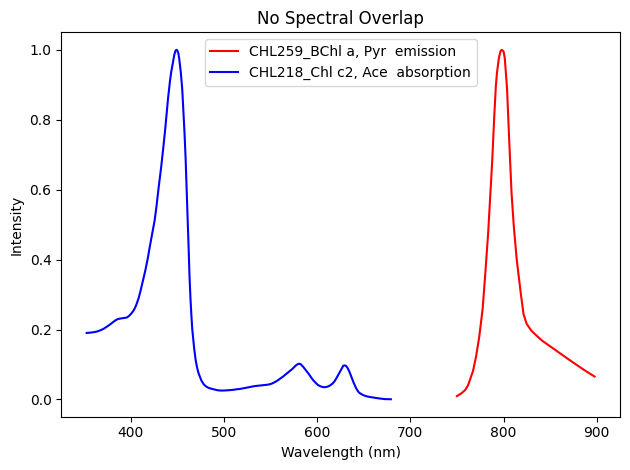

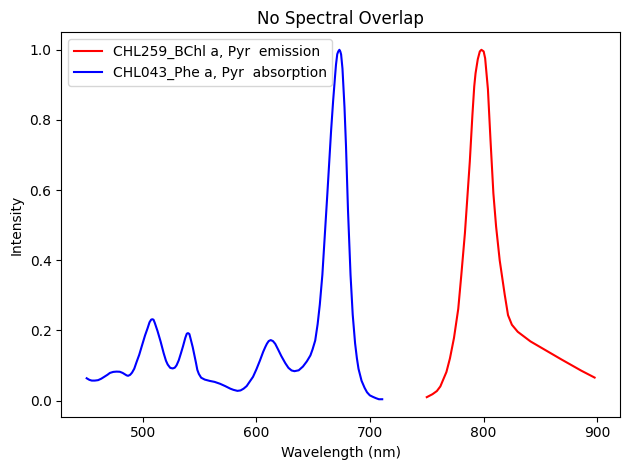

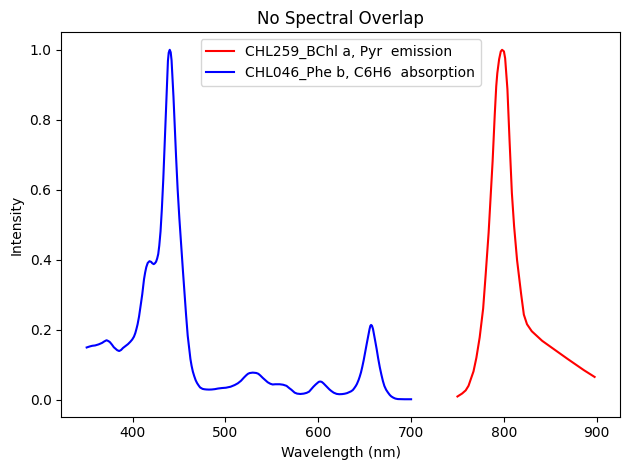

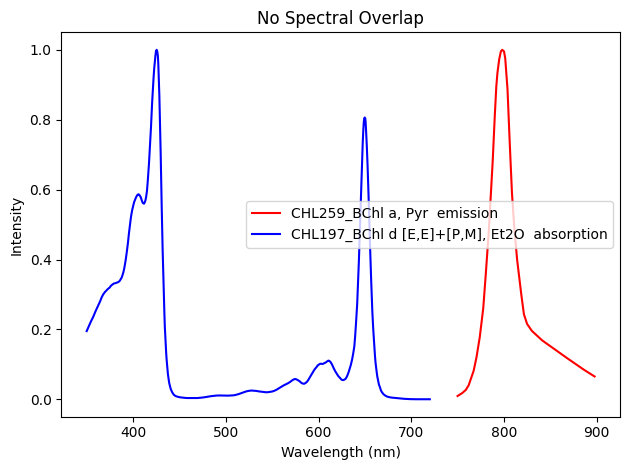

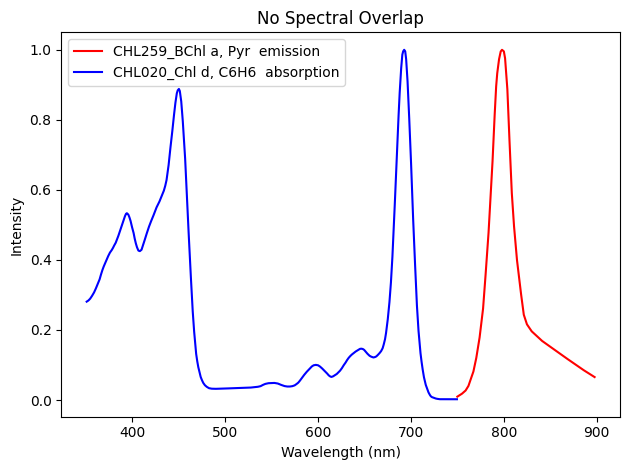

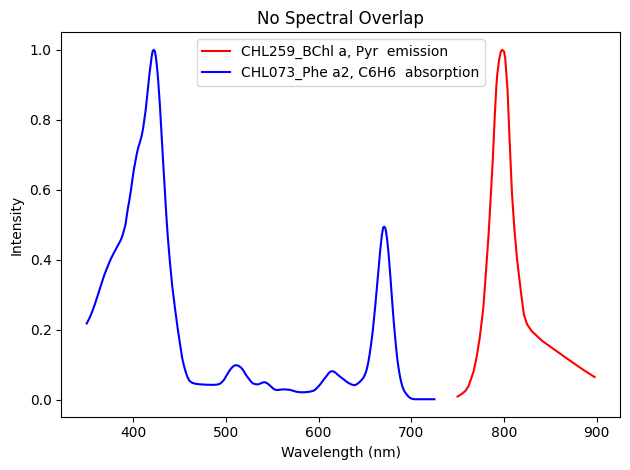

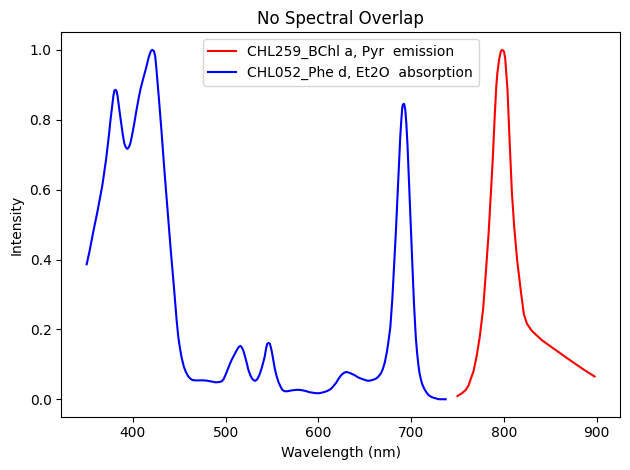

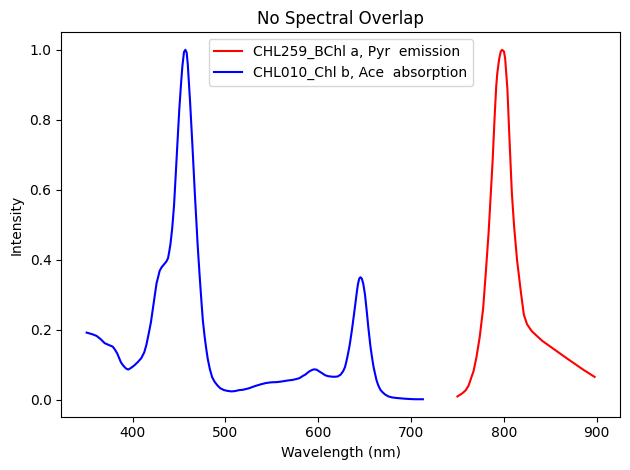

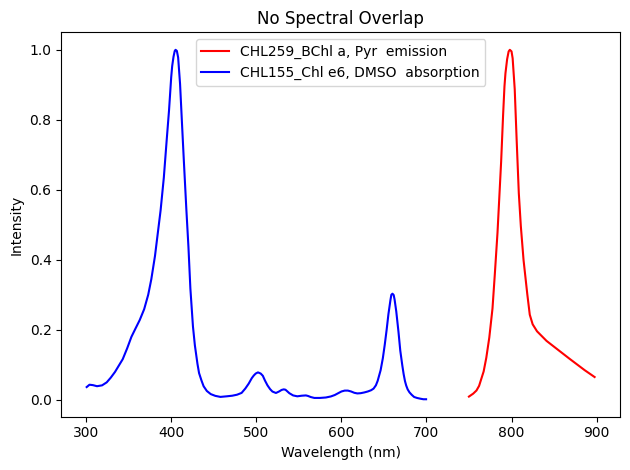

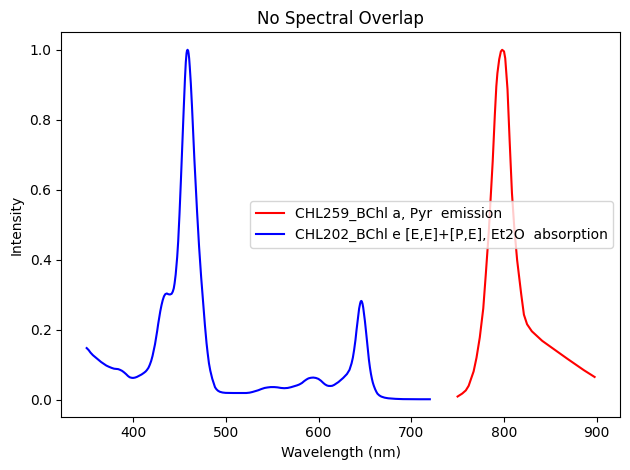

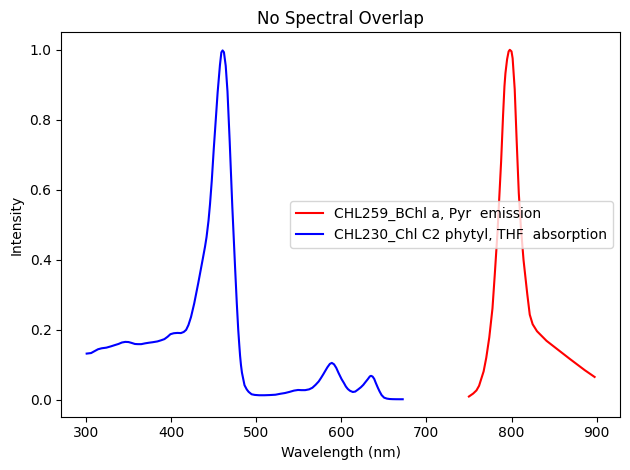

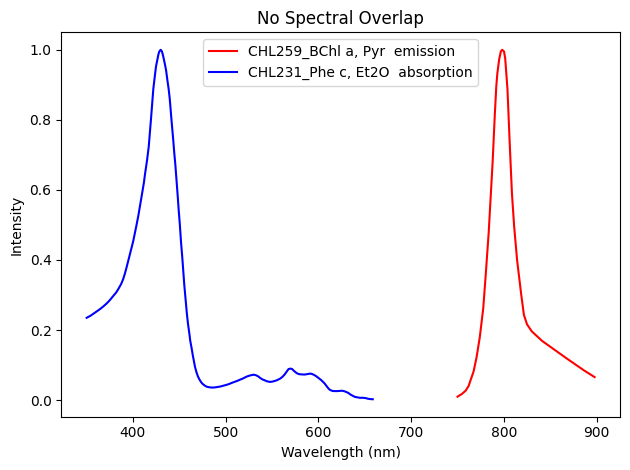

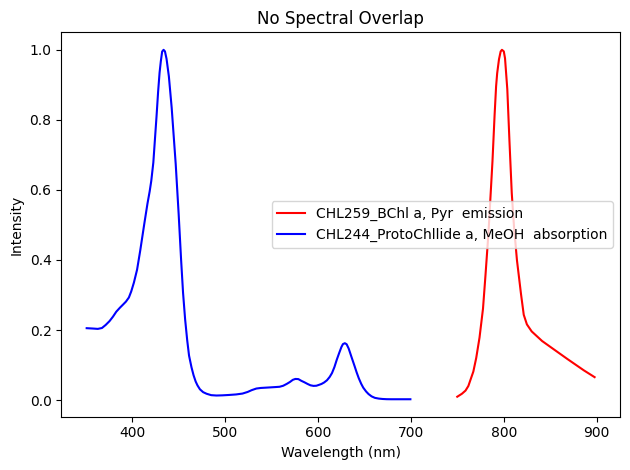

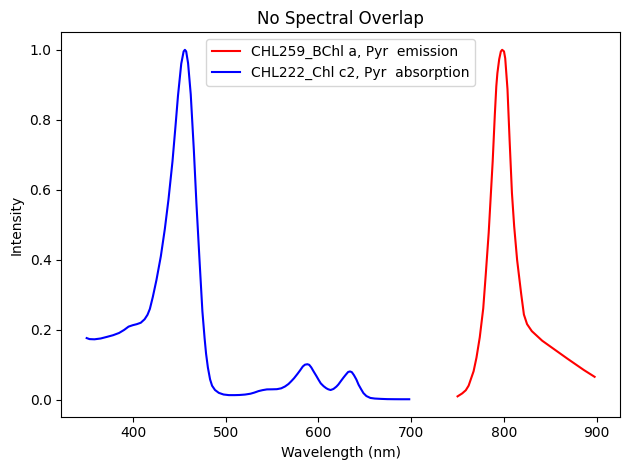

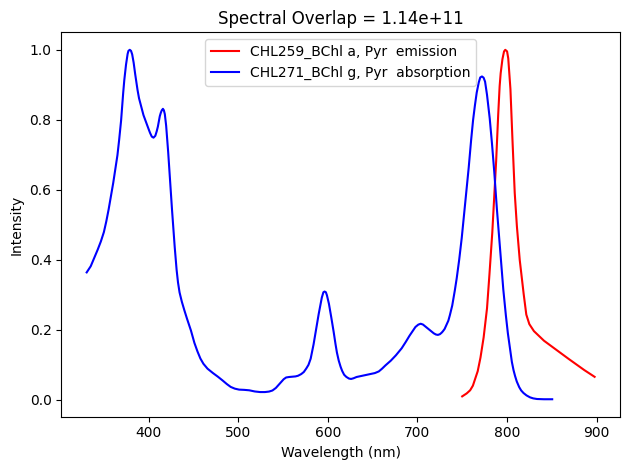

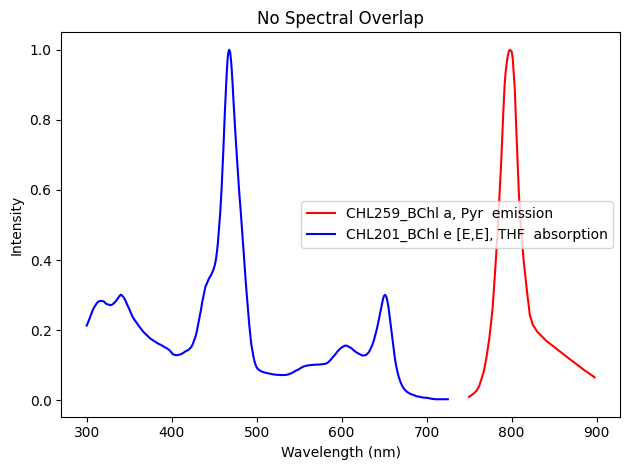

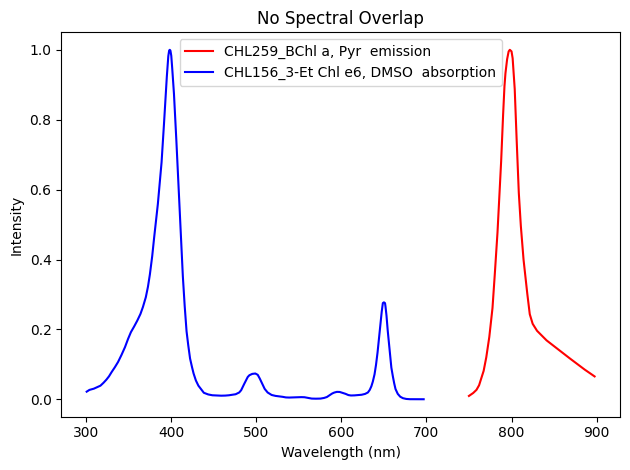

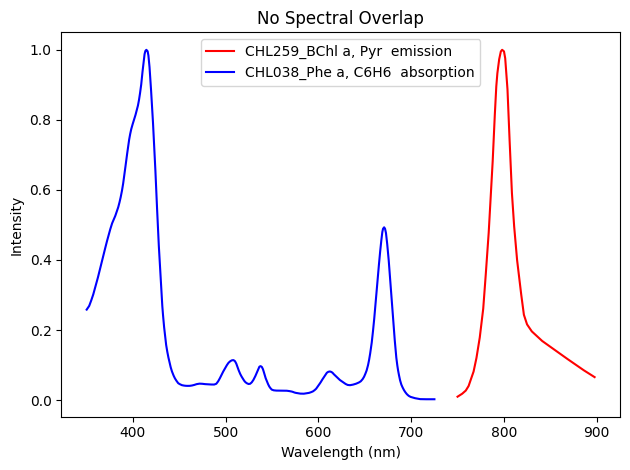

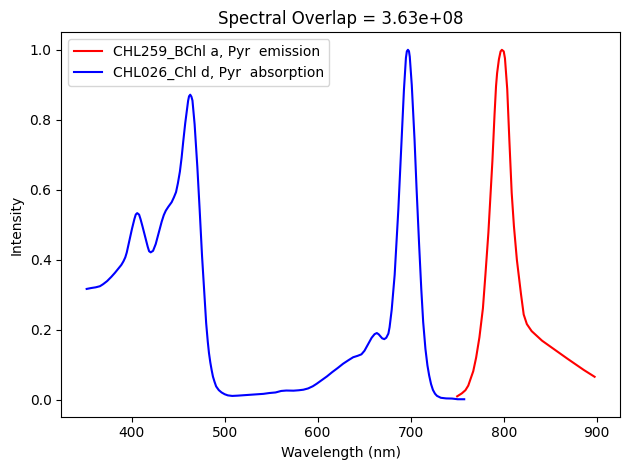

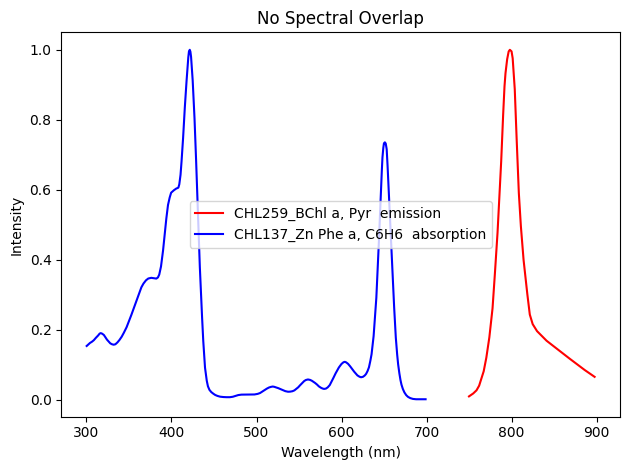

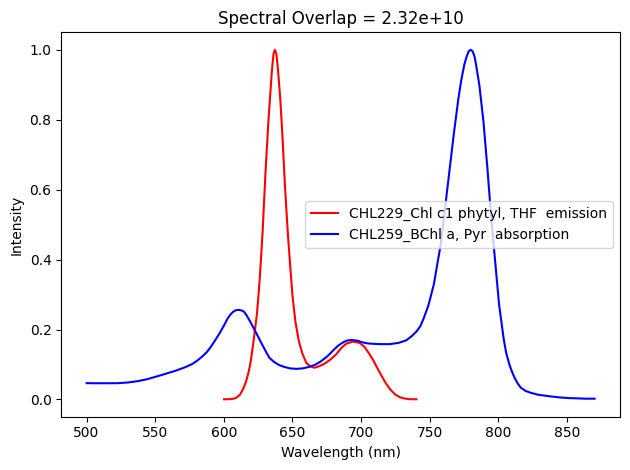

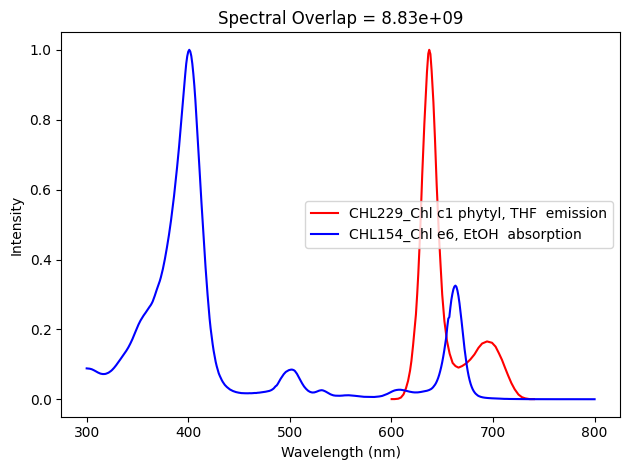

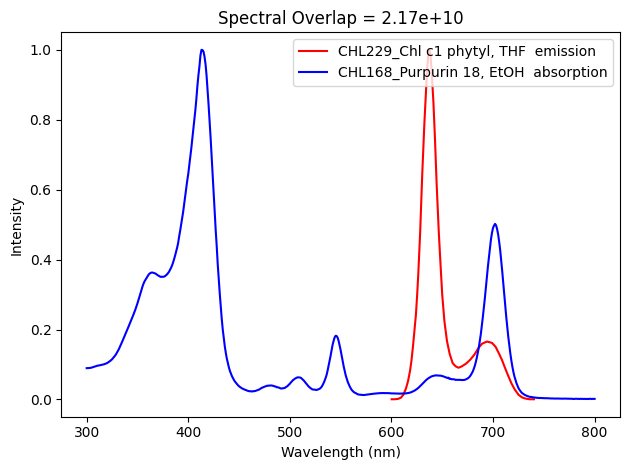

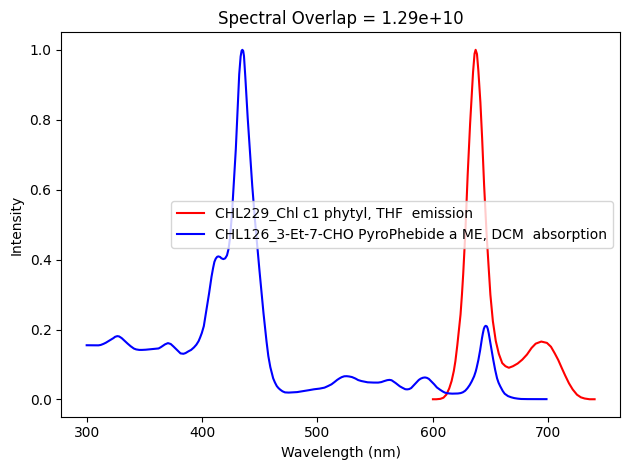

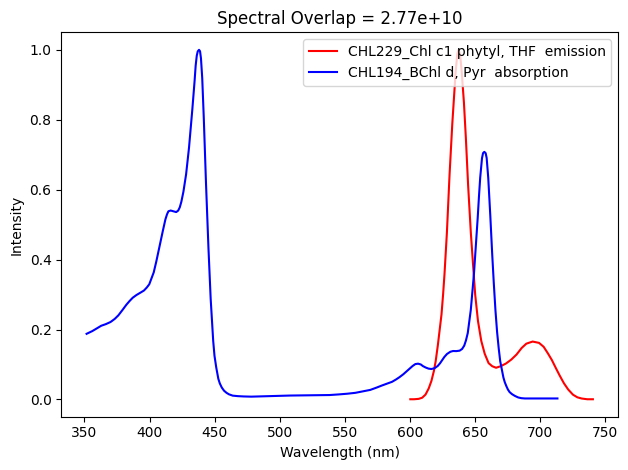

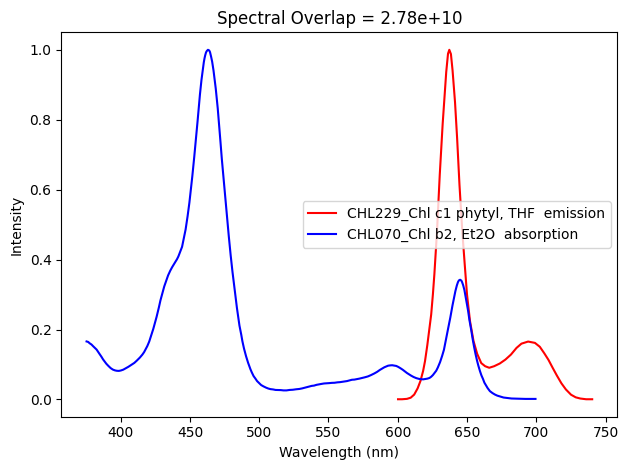

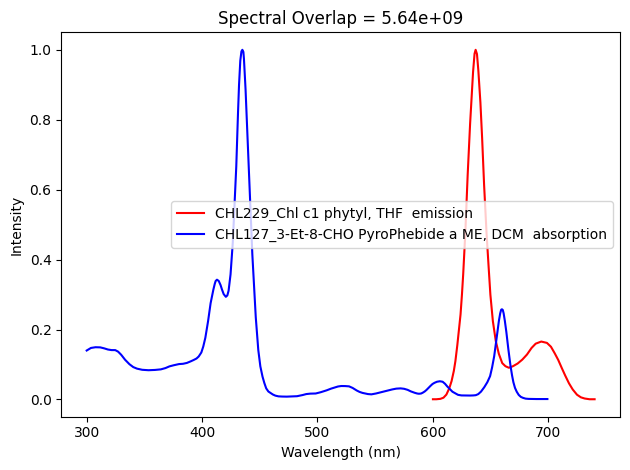

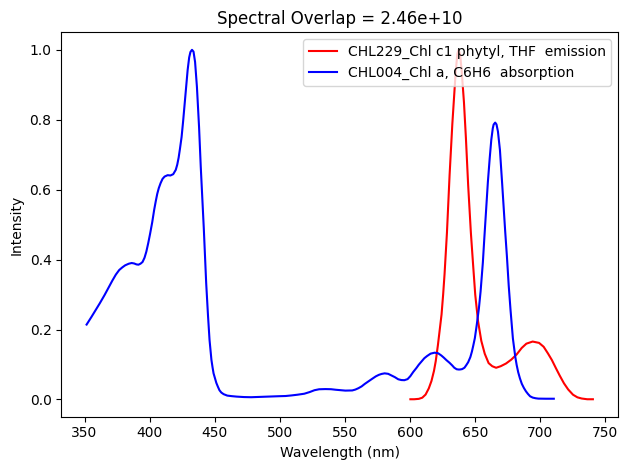

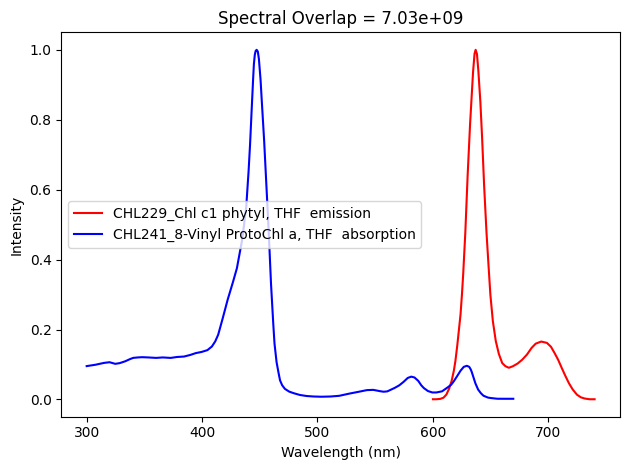

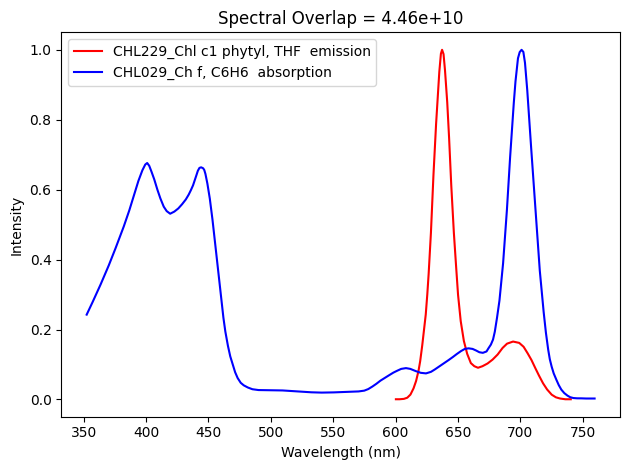

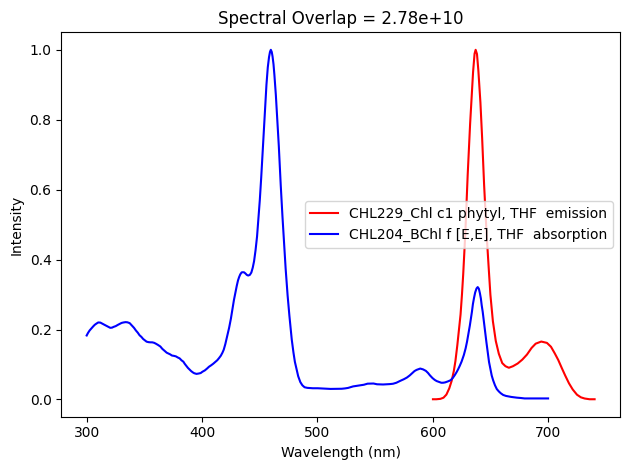

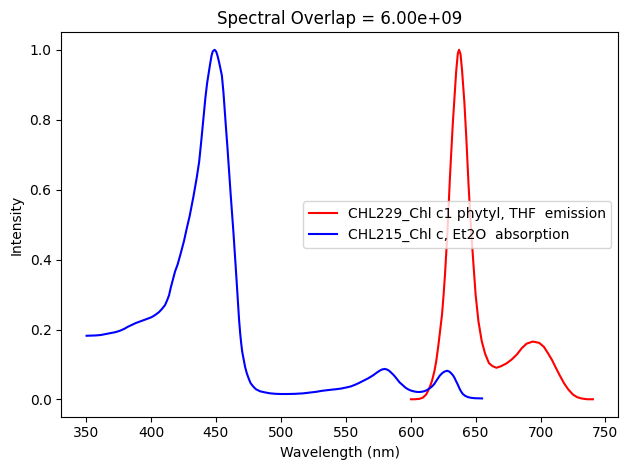

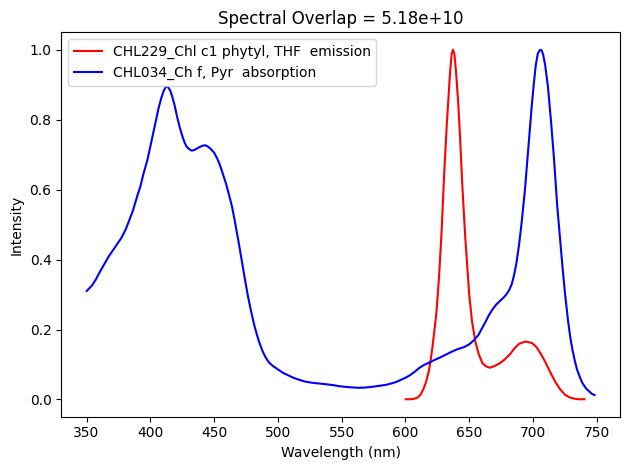

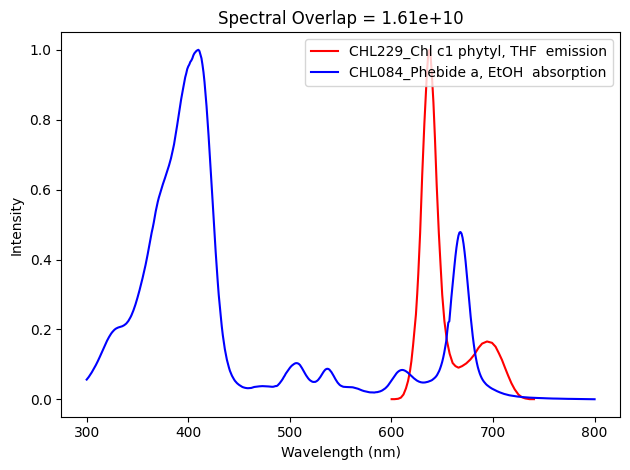

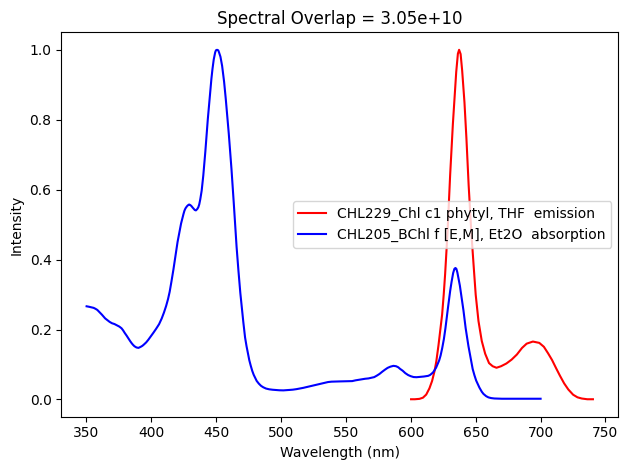

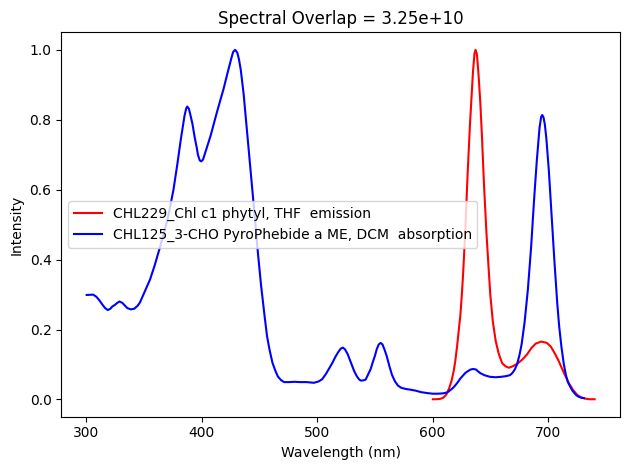

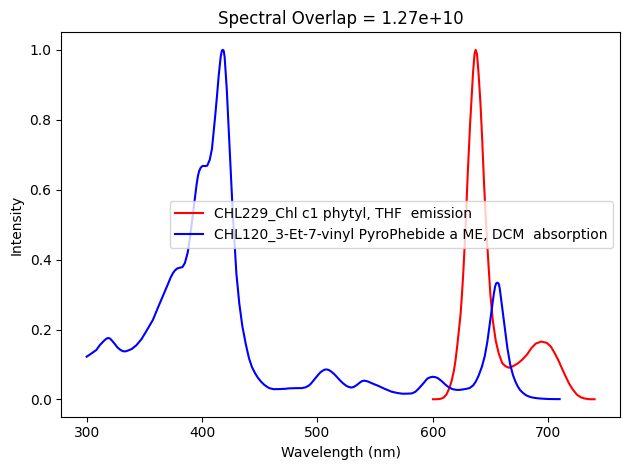

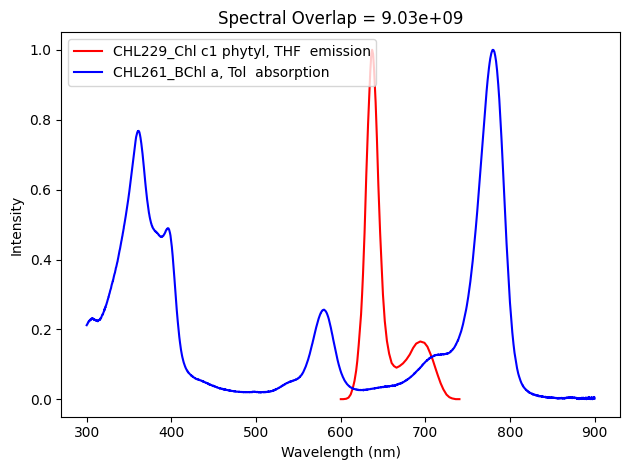

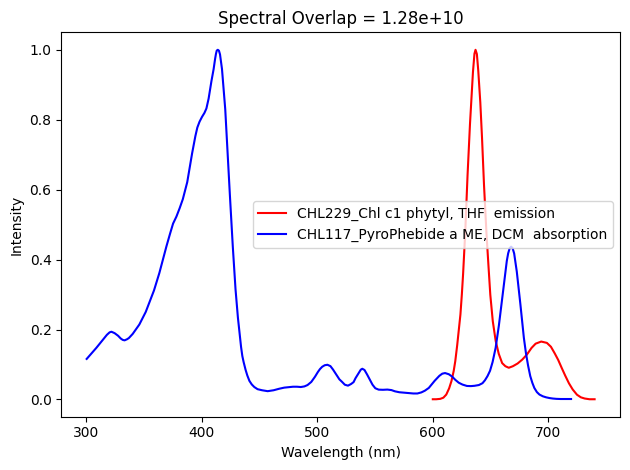

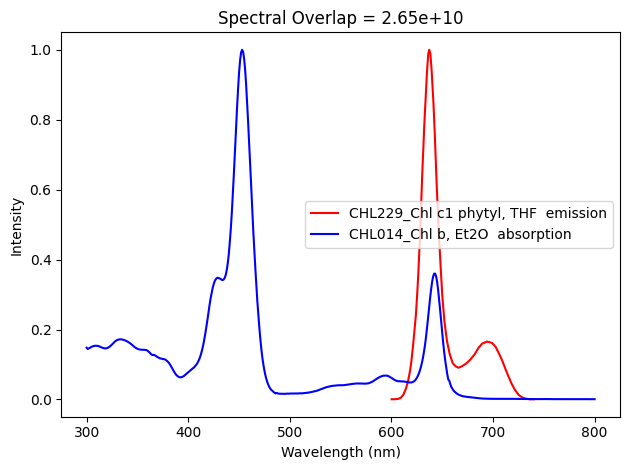

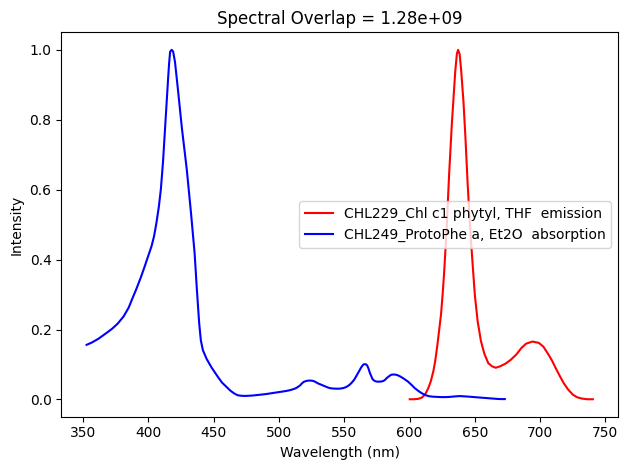

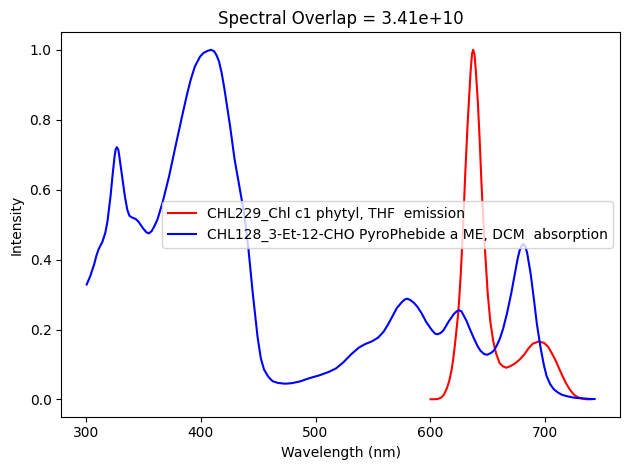

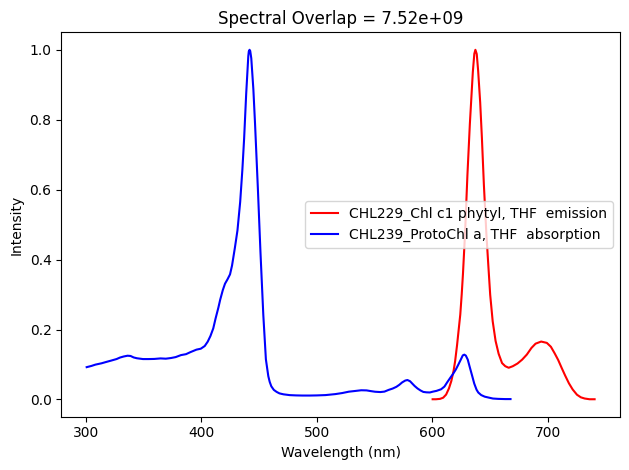

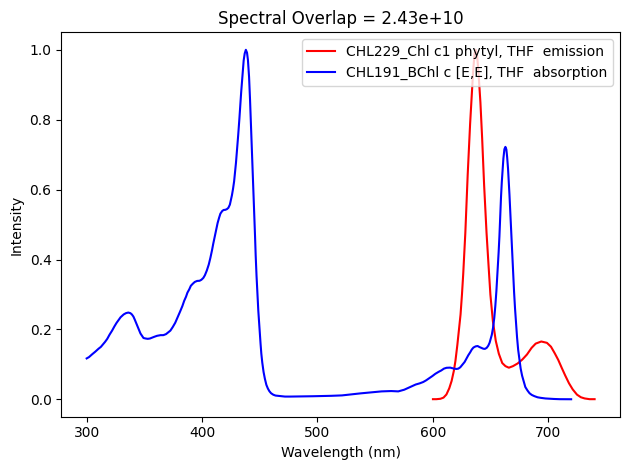

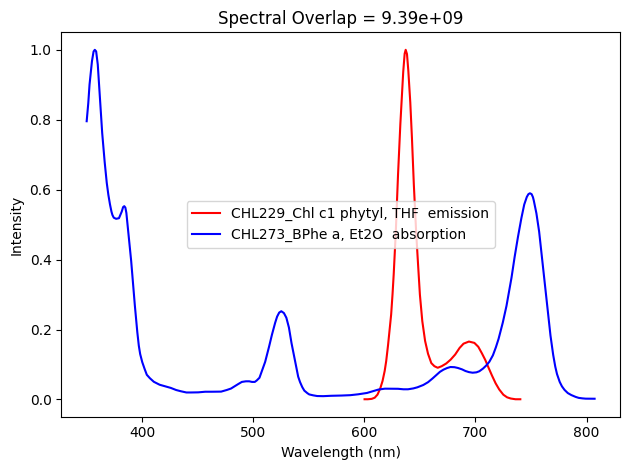

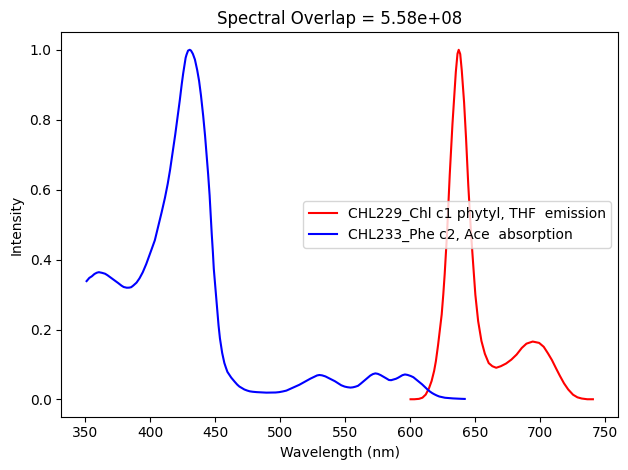

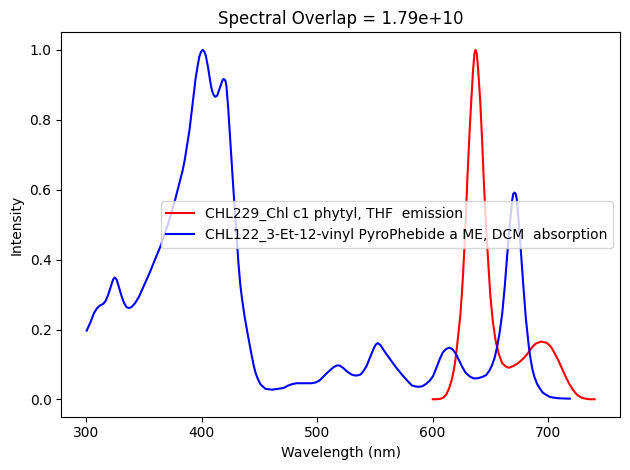

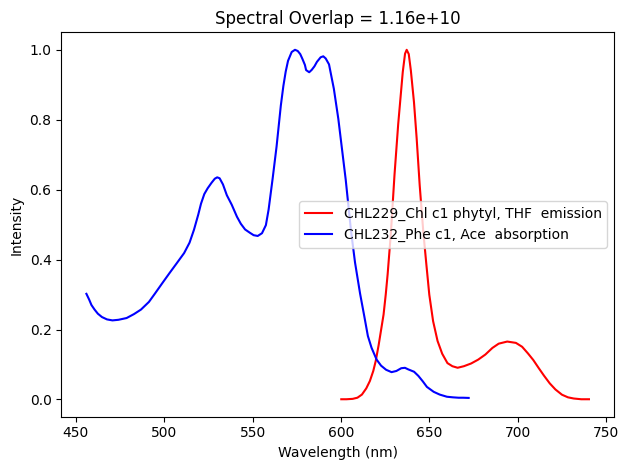

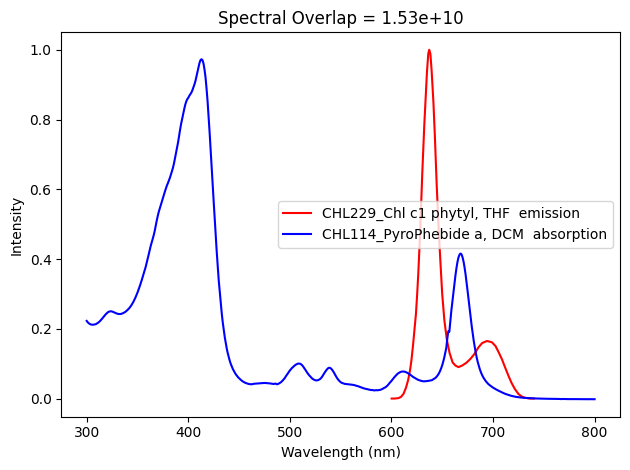

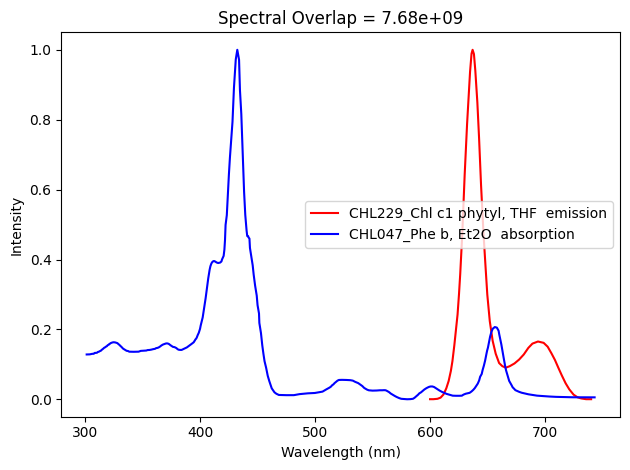

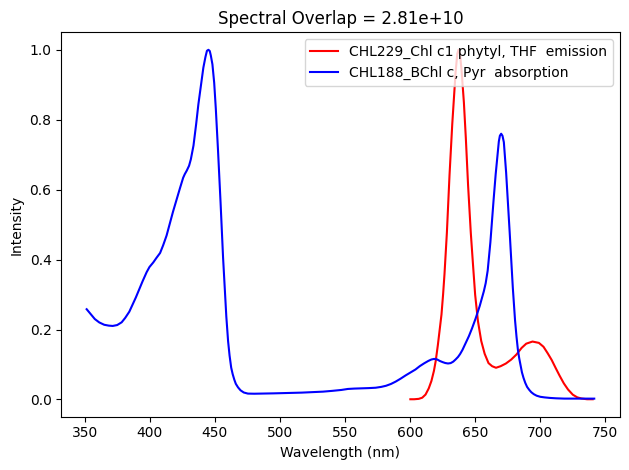

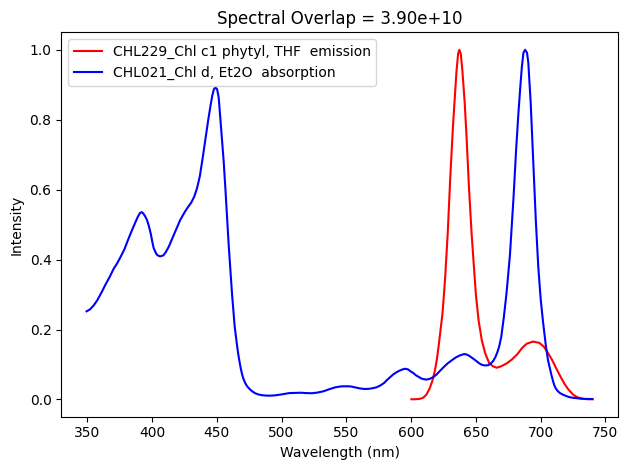

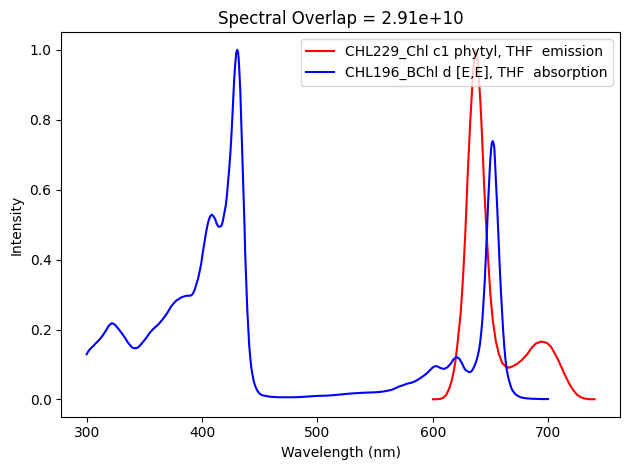

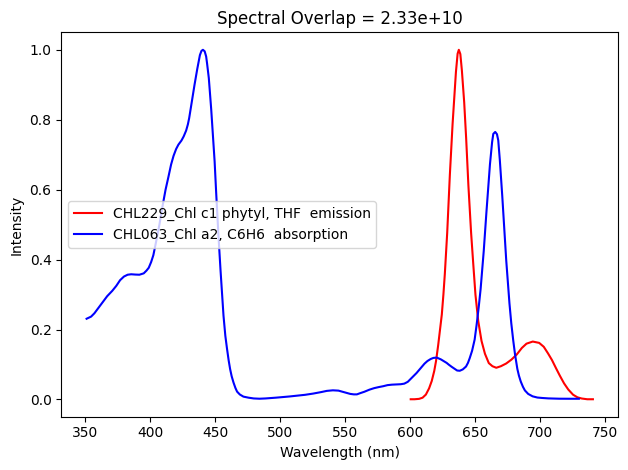

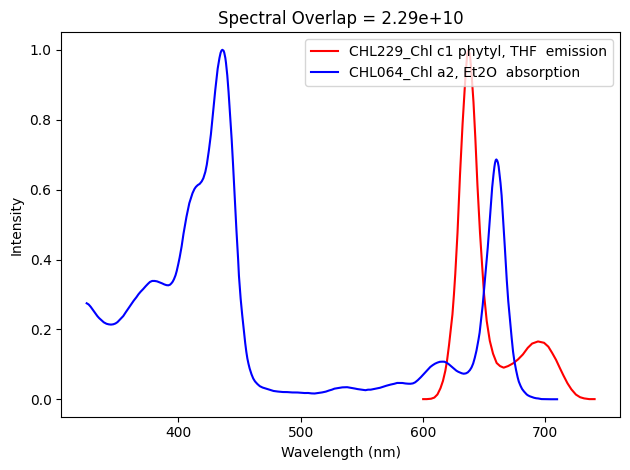

In [7]:
# Iterate through all key permutations and get plots
compound_pairs = list(itertools.permutations(chlorophyll_spectra.keys(), 2))
for i, cpair in enumerate(compound_pairs):
    if i < 100:
        save_path = './spectral_images/' + 'ems_' + cpair[0] + '_abs_' + cpair[1] + '.png'
        plot_spectra(cpair[0], cpair[1], chlorophyll_spectra, save_path=save_path)